<a href="https://colab.research.google.com/github/SarveshKanneganti/Sql-P1/blob/main/Social_Media_Sentiment_%26_Engagement_Analytics_(Twitter%E2%80%94US_Airlines).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib plotly nltk textblob scikit-learn wordcloud emoji==2.12.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.4 MB/s eta 0:00:00


In [2]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [3]:
!python -c "import nltk; [nltk.download(pkg) for pkg in ['stopwords','punkt','wordnet','omw-1.4','vader_lexicon']]"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Import Libraries

In [4]:
# Core
import os, re, math, json, string, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Natural Language Processing(NLP)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer  # VADER
from textblob import TextBlob

# Machine Learning(ML)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Utils
from wordcloud import WordCloud
import emoji

RANDOM_STATE = 42
pd.set_option('display.max_colwidth', 200)

1) Load Data & Overview

In [6]:
DATA_PATH = "/content/Tweets.csv"  # Kaggle 'Twitter US Airline Sentiment' dataset

df_raw = pd.read_csv(DATA_PATH, encoding='utf-8')
print("Shape:", df_raw.shape)
df_raw.head(5)

Shape: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df_raw.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different flight to Chicago.,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to #BlackBerry10,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [9]:
df_raw.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


2. Data Cleaning & Pre-Processing


# Keep only relevant columns

In [10]:
df = df_raw.copy()

# Keep only relevant columns
keep_cols = ['airline_sentiment','text','airline','tweet_created','negativereason','retweet_count']
for c in keep_cols:
    if c not in df.columns:
        df[c] = np.nan
df = df[keep_cols]

In [11]:
df.columns

Index(['airline_sentiment', 'text', 'airline', 'tweet_created',
       'negativereason', 'retweet_count'],
      dtype='object')

# Parse datetime

In [12]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'], errors='coerce')

# Drop duplicates & obvious empties

In [13]:
df.drop_duplicates(subset=['text'], inplace=True)
df = df[df['text'].notna() & (df['text'].str.strip()!='')].copy()
df.reset_index(drop=True, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14427 entries, 0 to 14426
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype                    
---  ------             --------------  -----                    
 0   airline_sentiment  14427 non-null  object                   
 1   text               14427 non-null  object                   
 2   airline            14427 non-null  object                   
 3   tweet_created      14427 non-null  datetime64[ns, UTC-08:00]
 4   negativereason     9080 non-null   object                   
 5   retweet_count      14427 non-null  int64                    
dtypes: datetime64[ns, UTC-08:00](1), int64(1), object(4)
memory usage: 676.4+ KB


#Text normalization helpers

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
url_pattern = re.compile(r'http\S+|www\.\S+')
mention_pattern = re.compile(r'@\w+')
hashtag_pattern = re.compile(r'#')
multi_space_pattern = re.compile(r'\s+')

def clean_text(s):
    s = s.lower()
    s = url_pattern.sub(' ', s)
    s = mention_pattern.sub(' ', s)
    s = hashtag_pattern.sub('', s)
    s = emoji.replace_emoji(s, replace=' ')  # remove emojis as spaces
    s = s.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(s)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    s = ' '.join(tokens)
    s = multi_space_pattern.sub(' ', s).strip()
    return s

df['clean_text'] = df['text'].apply(clean_text)

In [16]:
df.head(3)

,airline_sentiment,text,airline,tweet_created,negativereason,retweet_count,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,Virgin America,2015-02-24 11:35:52-08:00,NaN,0,said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,Virgin America,2015-02-24 11:15:59-08:00,NaN,0,plus youve added commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,Virgin America,2015-02-24 11:15:48-08:00,NaN,0,didnt today must mean need take another trip


# Drop very short cleaned texts (noise)

In [18]:
df = df[df['clean_text'].str.split().str.len() >= 3].copy()
df.reset_index(drop=True, inplace=True)

df.head(4)

,airline_sentiment,text,airline,tweet_created,negativereason,retweet_count,clean_text
0,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,Virgin America,2015-02-24 11:15:59-08:00,NaN,0,plus youve added commercial experience tacky
1,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,Virgin America,2015-02-24 11:15:48-08:00,NaN,0,didnt today must mean need take another trip
2,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",Virgin America,2015-02-24 11:15:36-08:00,Bad Flight,0,really aggressive blast obnoxious entertainment guest face amp little recourse
3,negative,@VirginAmerica and it's a really big bad thing about it,Virgin America,2015-02-24 11:14:45-08:00,Can't Tell,0,really big bad thing


In [19]:
df.isnull().sum()


,0
airline_sentiment,0
text,0
airline,0
tweet_created,0
negativereason,4655
retweet_count,0
clean_text,0


3) Exploratory Data Analysis (EDA)

3.1 Summary

In [20]:
print(df['airline_sentiment'].value_counts(dropna=False))
print(df['airline'].value_counts().head(10))
print(df[['retweet_count']].describe())
print(df['tweet_created'].agg(['min','max']))

airline_sentiment
negative    8842
neutral     2653
positive    2002
Name: count, dtype: int64
airline
United            3575
US Airways        2779
American          2445
Southwest         2250
Delta             1987
Virgin America     461
Name: count, dtype: int64
       retweet_count
count   13497.000000
mean        0.088390
std         0.775455
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        44.000000
min   2015-02-16 23:36:05-08:00
max   2015-02-24 11:53:37-08:00
Name: tweet_created, dtype: datetime64[ns, UTC-08:00]


3.2 Class distribution

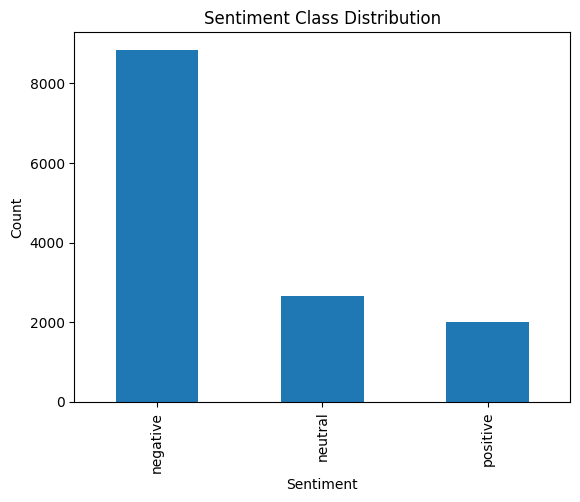

In [21]:
counts = df['airline_sentiment'].value_counts()
plt.figure()
counts.plot(kind='bar')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

3.3 Percentage wise Class Distribution

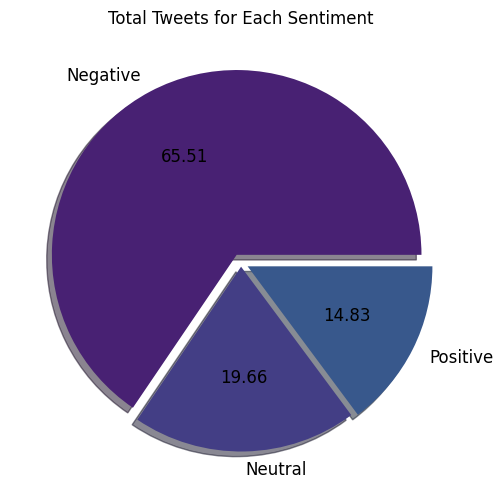

In [22]:
# Use the 'counts' variable which holds the sentiment distribution
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=['Negative', 'Neutral', 'Positive'], colors=sns.color_palette('viridis', 10), explode=[0.05, 0.02, 0.04], shadow=True, autopct='%.2f', textprops={'fontsize': 12})

# Set the title on the Axes object
plt.title('Total Tweets for Each Sentiment')

plt.show()

3.4 Tweets over time

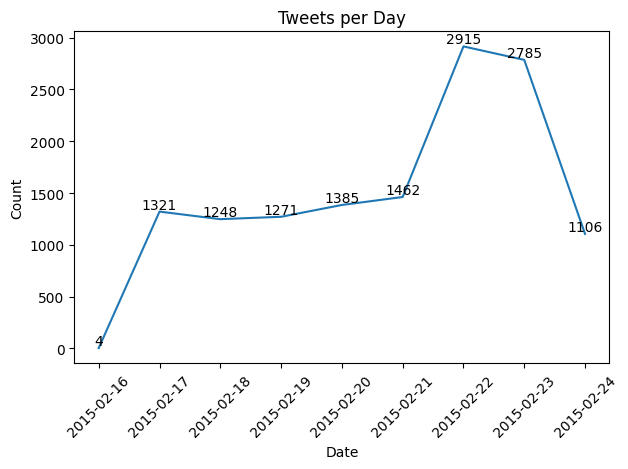

In [24]:
df['date'] = df['tweet_created'].dt.date
daily = df.groupby('date').size().reset_index(name='count')

plt.figure()
plt.plot(daily['date'], daily['count'])
plt.title('Tweets per Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add numbers to the data points
for i, count in enumerate(daily['count']):
    plt.text(daily['date'][i], count, str(count), ha='center', va='bottom')


plt.tight_layout()
plt.show()

3.5 Volume per Airline

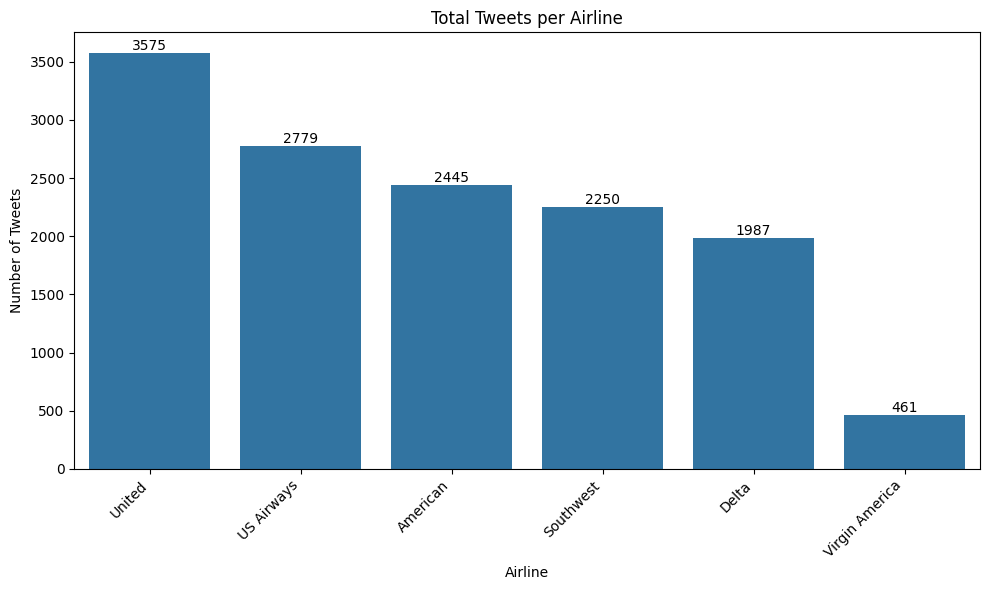

In [26]:
airline_counts = df['airline'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=airline_counts.index, y=airline_counts.values)
plt.title('Total Tweets per Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')

# Add numerical results on top of each bar
for i, count in enumerate(airline_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

3.6 Sentiment wise distribution per Airline

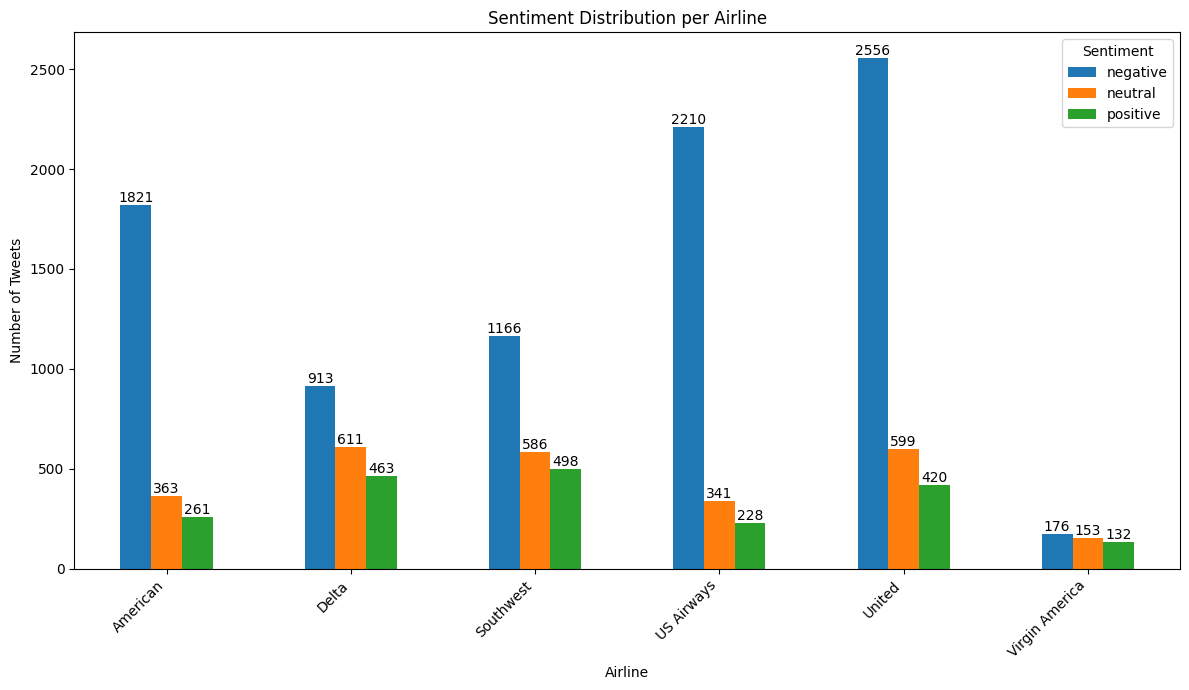

In [28]:
sentiment_by_airline = df.groupby(['airline', 'airline_sentiment']).size().unstack(fill_value=0)

sentiment_by_airline.plot(kind='bar', figsize=(12, 7))
plt.title('Sentiment Distribution per Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')

# Add numerical labels on top of each bar
for container in plt.gca().containers:
    plt.bar_label(container)

plt.tight_layout()
plt.show()

3.7 Most Frequent Negative Responses

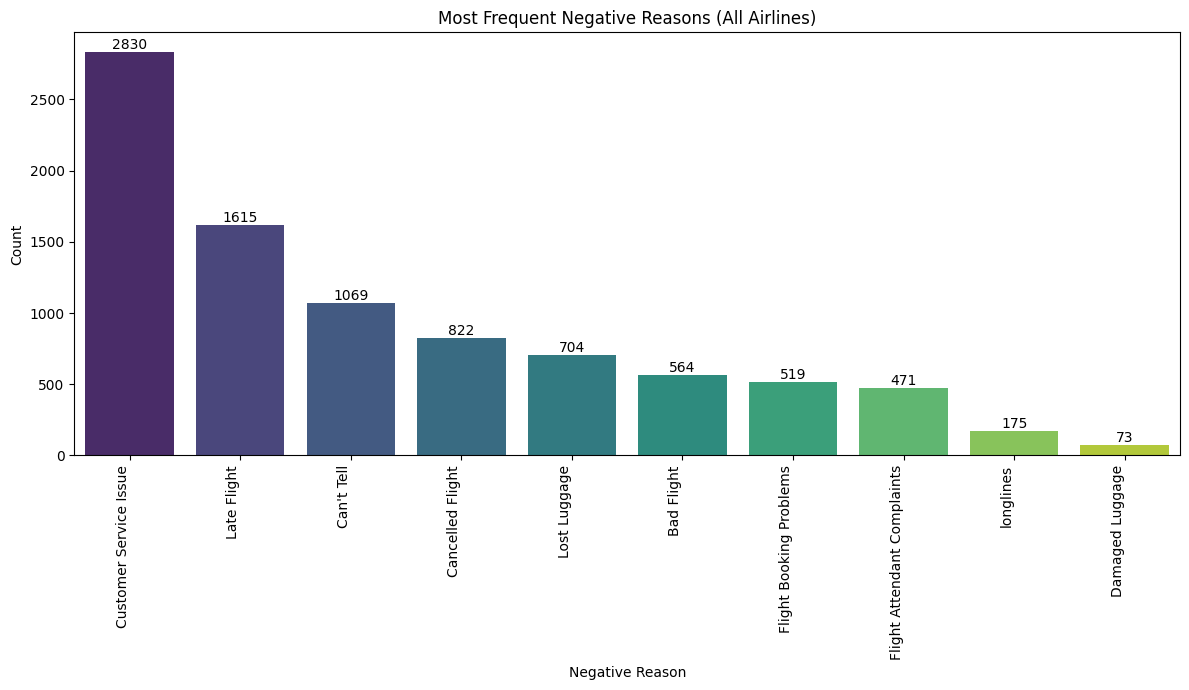

In [29]:
negative_tweets = df[df['airline_sentiment'] == 'negative']
negative_reason_counts = negative_tweets['negativereason'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=negative_reason_counts.index, y=negative_reason_counts.values, palette='viridis')
plt.title('Most Frequent Negative Reasons (All Airlines)')
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')

# Add numerical labels on top of each bar
for i, count in enumerate(negative_reason_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

3.8 Negative Responses by Airline wise

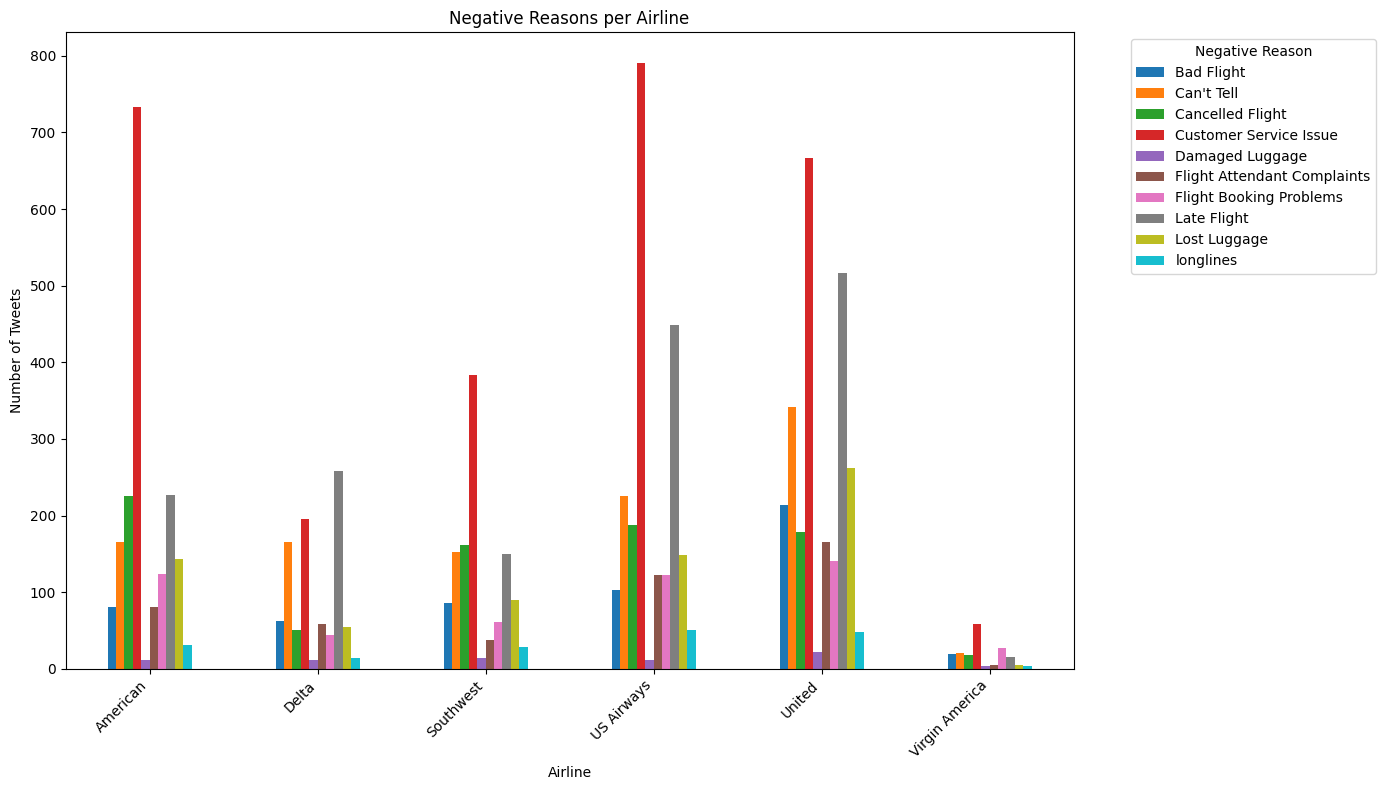

In [30]:
negative_reason_by_airline = negative_tweets.groupby(['airline', 'negativereason']).size().unstack(fill_value=0)

negative_reason_by_airline.plot(kind='bar', figsize=(14, 8))
plt.title('Negative Reasons per Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Negative Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

3.9 Most frequent words/hashtags (rudimentary)

In [36]:
from collections import Counter

all_tokens = ' '.join(df['clean_text']).split()
top_words = Counter(all_tokens).most_common(20)
pd.DataFrame(top_words, columns=['word','freq']).head(20)


,word,freq
0,flight,4427
1,get,1356
2,hour,1118
3,cancelled,1033
4,u,995
5,service,975
6,time,932
7,thanks,930
8,customer,920
9,help,844


4) Sentiment Analysis

In [37]:
sia = SentimentIntensityAnalyzer()

def vader_polarity(text):
    s = sia.polarity_scores(text)
    return s['compound']

def tb_polarity(text):
    return TextBlob(text).sentiment.polarity

df['vader_compound'] = df['text'].astype(str).apply(vader_polarity)
df['textblob_polarity'] = df['text'].astype(str).apply(tb_polarity)

# Map to labels from VADER (simple rule)
def label_from_compound(c):
    if c >= 0.05:
        return 'positive'
    elif c <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_label'] = df['vader_compound'].apply(label_from_compound)

# Compare dataset label vs VADER label (if dataset has label)
if 'airline_sentiment' in df.columns:
    cm = pd.crosstab(df['airline_sentiment'], df['vader_label'])
    print("Dataset vs VADER label (counts):\n", cm)


Dataset vs VADER label (counts):
 vader_label        negative  neutral  positive
airline_sentiment                             
negative               4430     1750      2662
neutral                 412     1021      1220
positive                 86      175      1741


4.1 Sentiment Distributions

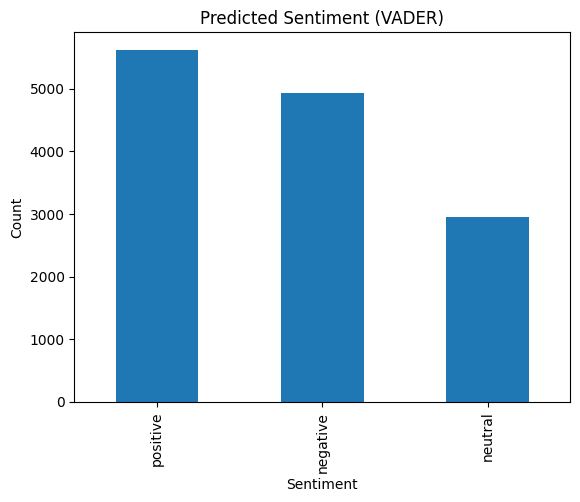

In [38]:
plt.figure()
df['vader_label'].value_counts().plot(kind='bar')
plt.title('Predicted Sentiment (VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


4.2 Sentiment Over Time

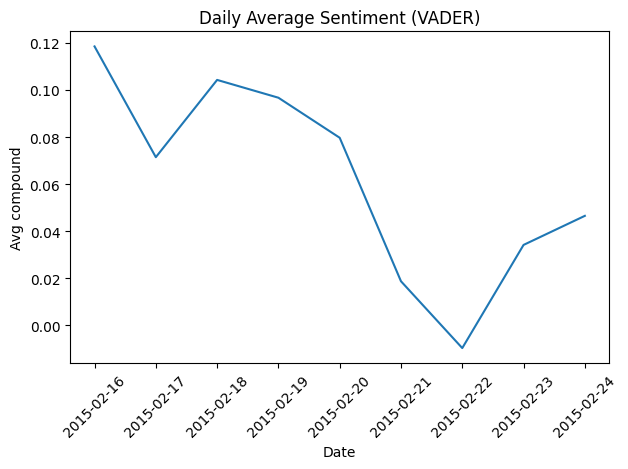

In [39]:
sent_daily = df.groupby(['date'])['vader_compound'].mean().reset_index()
plt.figure()
plt.plot(sent_daily['date'], sent_daily['vader_compound'])
plt.title('Daily Average Sentiment (VADER)')
plt.xlabel('Date')
plt.ylabel('Avg compound')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


4.3 Engagement vs sentiment (if retweet_count exists)

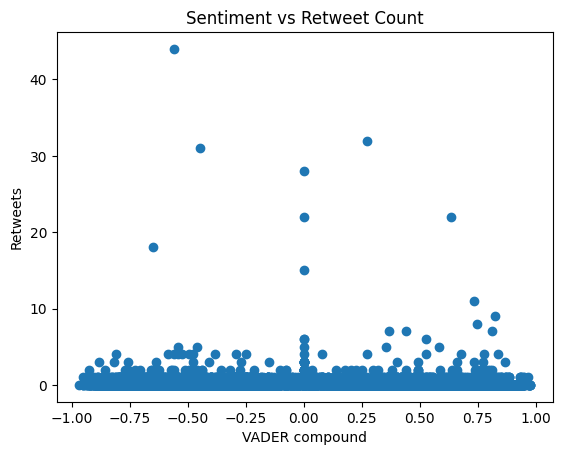

,vader_label,tweets,avg_compound,avg_retweets
0,negative,4928,-0.450522,0.105722
1,neutral,2946,0.000324,0.086219
2,positive,5623,0.502106,0.074338


In [40]:
if 'retweet_count' in df.columns:
    plt.figure()
    plt.scatter(df['vader_compound'], df['retweet_count'])
    plt.title('Sentiment vs Retweet Count')
    plt.xlabel('VADER compound')
    plt.ylabel('Retweets')
    plt.show()

# Grouped stats by sentiment
agg = df.groupby('vader_label').agg(
    tweets=('text','count'),
    avg_compound=('vader_compound','mean'),
    avg_retweets=('retweet_count','mean')
).reset_index()
agg


5) Topic Clustering with TF-IDF + KMeans

In [43]:
# Vectorize cleaned text
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), min_df=3)
X = tfidf.fit_transform(df['clean_text'])

# Choose K using a quick sweep (elbow-ish + silhouette)
K_RANGE = range(3, 9)
scores = []
sil = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(X)
    scores.append(km.inertia_)
    sil.append(silhouette_score(X, labels))

print("Inertia by K:", dict(zip(K_RANGE, scores)))
print("Silhouette by K:", dict(zip(K_RANGE, np.round(sil,3))))

# Pick K (e.g., best silhouette)
best_k = K_RANGE[int(np.argmax(sil))]
km_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
df['topic_km'] = km_final.fit_predict(X)

# Top terms per cluster
def top_terms_per_cluster(km_model, tfidf_vectorizer, topn=15):
    terms = np.array(tfidf_vectorizer.get_feature_names_out())
    centers = km_model.cluster_centers_
    out = {}
    for i in range(centers.shape[0]):
        idx = centers[i].argsort()[-topn:][::-1]
        out[i] = terms[idx].tolist()
    return out

terms = top_terms_per_cluster(km_final, tfidf, topn=12)
json.dumps(terms, indent=2)


Inertia by K: {3: 13302.116252364456, 4: 13273.863038040354, 5: 13250.79443921264, 6: 13227.108699138476, 7: 13194.741918899761, 8: 13136.095043337762}
Silhouette by K: {3: np.float64(0.003), 4: np.float64(0.003), 5: np.float64(0.003), 6: np.float64(0.004), 7: np.float64(0.005), 8: np.float64(0.006)}


'{\n  "0": [\n    "great",\n    "great job",\n    "great flight",\n    "flight",\n    "job",\n    "thanks",\n    "great service",\n    "thank",\n    "crew",\n    "service",\n    "would great",\n    "thanks great"\n  ],\n  "1": [\n    "customer service",\n    "customer",\n    "service",\n    "worst customer",\n    "worst",\n    "ever",\n    "poor",\n    "flight",\n    "terrible",\n    "poor customer",\n    "call",\n    "phone"\n  ],\n  "2": [\n    "thanks",\n    "flight",\n    "response",\n    "reply",\n    "thanks help",\n    "help",\n    "much",\n    "thanks much",\n    "got",\n    "guy",\n    "get",\n    "bag"\n  ],\n  "3": [\n    "time",\n    "need",\n    "one",\n    "flight",\n    "get",\n    "help",\n    "plane",\n    "im",\n    "bag",\n    "call",\n    "first",\n    "please"\n  ],\n  "4": [\n    "hour",\n    "hold",\n    "flight",\n    "hold hour",\n    "plane",\n    "waiting",\n    "delay",\n    "delayed",\n    "hour delay",\n    "hour late",\n    "late",\n    "get"\n  ],\n  "5"

5.1 Topic distribution & engagement by topic

In [46]:
topic_stats = df.groupby('topic_km').agg(
    tweets=('text','count'),
    avg_sent=('vader_compound','mean'),
    avg_rt=('retweet_count','mean')
).reset_index().sort_values('tweets', ascending=False)
topic_stats


,topic_km,tweets,avg_sent,avg_rt
5,5,6721,0.062307,0.097902
7,7,2310,-0.041667,0.088745
3,3,1368,0.005851,0.069444
4,4,857,-0.114627,0.057176
2,2,753,0.501662,0.084993
6,6,655,-0.212976,0.067176
1,1,570,-0.074678,0.108772
0,0,263,0.669797,0.060837


6.1 Word Cloud(Positive)

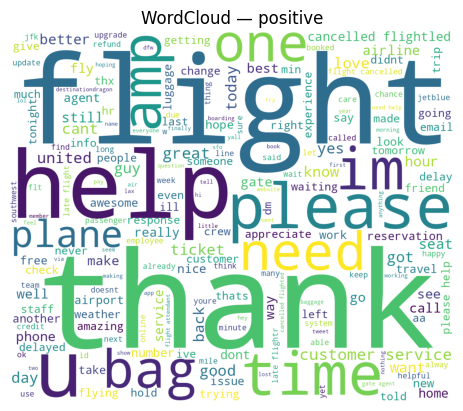

In [51]:
def plot_wordcloud(text_series, title):
    text = ' '.join(text_series)
    wc = WordCloud(width=1200, height=1000, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

for lab in ['positive']:
    subset = df.loc[df['vader_label']==lab, 'clean_text']
    if len(subset) > 50:
        plot_wordcloud(subset, f'WordCloud — {lab}')

6.2 World Cloud (Negative)

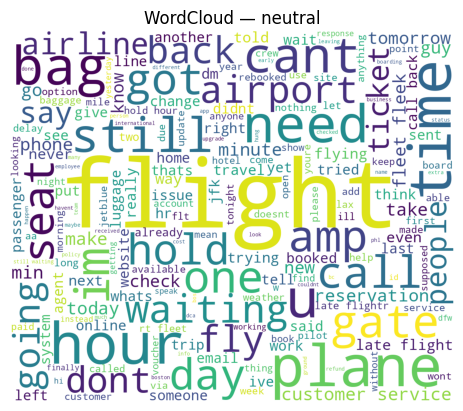

In [54]:
def plot_wordcloud(text_series, title):
    text = ' '.join(text_series)
    wc = WordCloud(width=1200, height=1000, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

for lab in ['neutral']:
    subset = df.loc[df['vader_label']==lab, 'clean_text']
    if len(subset) > 50:
        plot_wordcloud(subset, f'WordCloud — {lab}')

6.3 World Cloud (Negative)

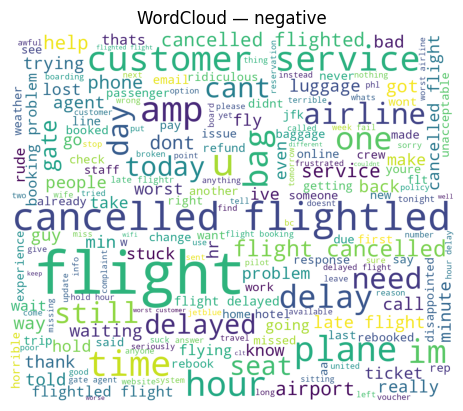

In [55]:
def plot_wordcloud(text_series, title):
    text = ' '.join(text_series)
    wc = WordCloud(width=1200, height=1000, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

for lab in ['negative']:
    subset = df.loc[df['vader_label']==lab, 'clean_text']
    if len(subset) > 50:
        plot_wordcloud(subset, f'WordCloud — {lab}')

7) Airline-level Insights (Business-oriented)

In [47]:
airline_summary = df.groupby('airline').agg(
    tweets=('text','count'),
    avg_sent=('vader_compound','mean'),
    pct_negative=('vader_label', lambda s: (s=='negative').mean()*100),
    pct_positive=('vader_label', lambda s: (s=='positive').mean()*100),
    avg_rt=('retweet_count','mean')
).reset_index().sort_values('tweets', ascending=False)

airline_summary


,airline,tweets,avg_sent,pct_negative,pct_positive,avg_rt
4,United,3575,0.023172,39.076923,40.923077,0.116643
3,US Airways,2779,-0.029445,42.533285,35.768262,0.088881
0,American,2445,0.002329,40.981595,39.672802,0.047035
2,Southwest,2250,0.129644,28.977778,48.622222,0.062667
1,Delta,1987,0.121442,28.887771,45.193759,0.124308
5,Virgin America,461,0.139732,26.247289,44.251627,0.056399


7.1 Average Sentiment per Airline

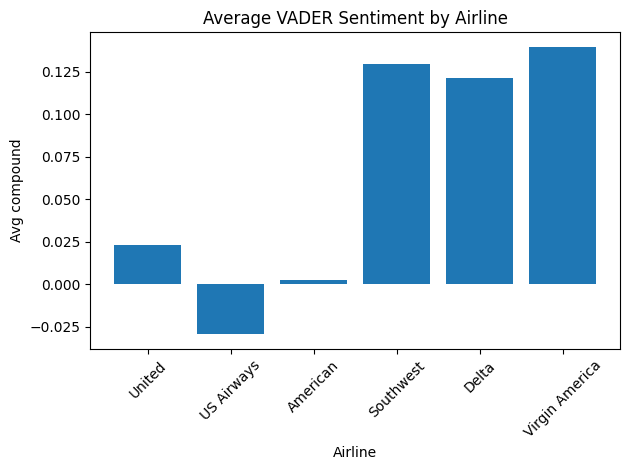

In [48]:
plt.figure()
plt.bar(airline_summary['airline'], airline_summary['avg_sent'])
plt.title('Average VADER Sentiment by Airline')
plt.xlabel('Airline')
plt.ylabel('Avg compound')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [56]:
# Sentiment over time (interactive)
fig = px.line(sent_daily, x='date', y='vader_compound', title='Daily Average Sentiment (Interactive)')
fig.show()

# Airline vs sentiment (interactive)
fig2 = px.bar(airline_summary, x='airline', y=['pct_negative','pct_positive'],
              title='Sentiment % by Airline', barmode='group')
fig2.show()


**Thank You!!!**